In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from symbolic_control import (
    IntegratorDynamics, Abstraction,
    RegionLabeler, regex_to_nfa,
    ProductSynthesis, ProductState
)

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from symbolic_control import IntegratorDynamics, Abstraction, ProductSynthesis

## Configuration Parameters

In [3]:
# ============================================================
# GRID PARAMETERS
# ============================================================
x_min, x_max = -5.0, 5.0    # Grid x bounds
y_min, y_max = -5.0, 5.0    # Grid y bounds
eta = 0.2                   # Cell size (larger for faster testing)

# ============================================================
# DYNAMICS PARAMETERS
# ============================================================
tau = 0.5                   # Time step
w_bound = 0.1               # Disturbance bound
u_values = np.linspace(-1, 1, num=5)  # Control values per axis

In [4]:
# ============================================================
# REGIONS (named regions on the grid)
# Format: 'name': [x_min, x_max, y_min, y_max]
# ============================================================
# Each region is just a labeled area. Use [^...] in the regex to avoid regions.
regions = {
    'A': [-4.5, -3, -4.5, -3],     # Bottom-left corner
    'B': [3, 4.5, 3, 4.5],          # Top-right corner
    'C': [-4, -3, -1, 1],           # Left side
    'P': [-1, 1, -3, 4],            # Center
    'Q': [-3, -1, 2, 4],            # Top-left
    'R': [1, 5, -3, 0],             # Bottom-right
    'S': [1, 2, 0, 5],              # Near B
    'T': [-2, -1.5, -3, 1]          # Left-center
}

# ============================================================
# SPECIFICATION (Regular Expression)
# ============================================================
# Use [^XYZ]* to avoid regions X, Y, Z while navigating
# Example: "A[^PQRST]*B" = go to A, then to B while avoiding P,Q,R,S,T
# spec = "A[^PQRST]*B[^PQRST]*C[^PQRST]*B"
spec = "A[^P]*B[^S]*T"

# ============================================================
# START POSITION
# ============================================================
start_position = np.array([0.0, -4.0])

## Setup Dynamics and Abstraction

In [5]:
# Create dynamics
dynamics = IntegratorDynamics(tau=tau, w_bound=w_bound, u_values=u_values)
print(f"Control set: {len(dynamics.control_set)} controls")

# Create abstraction
abstraction = Abstraction(
    dynamics=dynamics,
    state_bounds=np.array([[x_min, x_max], [y_min, y_max]]),
    eta=eta
)
nx, ny = abstraction.grid_shape
print(f"\nGrid: {nx} x {ny} = {abstraction.num_cells} cells")

# Build transitions
print("\nBuilding transitions...")
abstraction.build_transitions()
print(f"Total transitions: {len(abstraction.transitions)}")

Control set: 25 controls

Grid: 50 x 50 = 2500 cells

Building transitions...
Building transitions for 2500 cells × 25 controls...
Done. Total transitions: 62500
Total transitions: 62500


## Run Product Synthesis

In [6]:
# Create product synthesis and run
# NOTE: obstacles are now specified in the regex via [^...] syntax
synth = ProductSynthesis(
    abstraction=abstraction,
    regions=regions,
    spec=spec
)

winning_set = synth.run(verbose=True)

Specification: A[^P]*B[^S]*T
NFA states: 14, alphabet: {'T', [^S], 'A', 'B', [^P]}

SAFETY SYNTHESIS (Automaton Pruning)
Qₛ: 2500 cells | R₀: 2500 cells
Iteration 1: 2500 cells (removed 0)
Converged! S* = 2500 cells (100.0%)
Safe transitions: 56644
PRODUCT AUTOMATON CONSTRUCTION
Initial product states: 2500
Accepting in initial: 0


KeyboardInterrupt: 

## Visualize Results

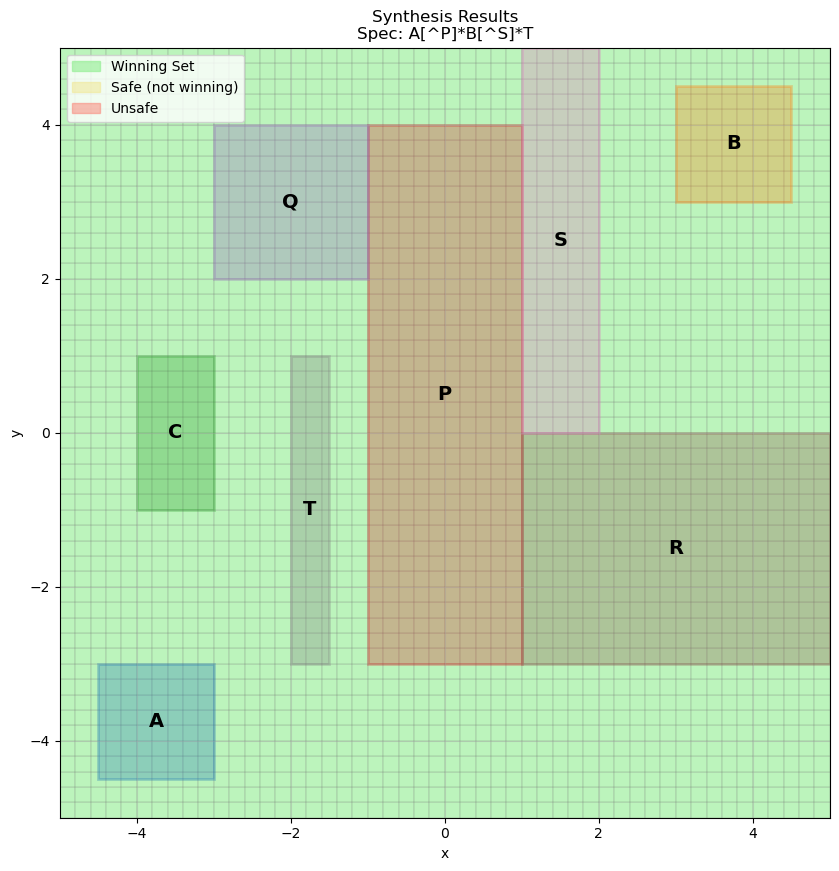

In [ ]:
def visualize_synthesis(synth, ax=None, title="Synthesis Results"):
    """Visualize the synthesis results.
    
    Args:
        synth: ProductSynthesis instance
        ax: matplotlib axes (optional)
        title: Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    abst = synth.abstraction
    nx, ny = abst.grid_shape
    
    # Get winning cells
    winning_cells = synth.get_winning_cells()
    safe_cells = synth.safe_automaton.safe_states if synth.safe_automaton else set()
    
    # Draw cells
    for i in range(nx):
        for j in range(ny):
            cell_idx = np.ravel_multi_index((i, j), abst.grid_shape)
            x = abst.state_bounds[0, 0] + i * abst.eta
            y = abst.state_bounds[1, 0] + j * abst.eta
            
            if cell_idx in winning_cells:
                color = 'lightgreen'
                alpha = 0.6
            elif cell_idx in safe_cells:
                color = 'khaki'
                alpha = 0.5
            else:
                color = 'salmon'
                alpha = 0.5
            
            rect = mpatches.Rectangle(
                (x, y), abst.eta, abst.eta,
                linewidth=0.3, edgecolor='gray',
                facecolor=color, alpha=alpha
            )
            ax.add_patch(rect)
    
    # Draw all named regions
    colors = plt.cm.tab10.colors
    for i, (name, bounds) in enumerate(synth.regions.items()):
        color = colors[i % len(colors)]
        rect = mpatches.Rectangle(
            (bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
            linewidth=2, edgecolor=color, facecolor=color, alpha=0.3
        )
        ax.add_patch(rect)
        ax.text(
            (bounds[0] + bounds[1]) / 2,
            (bounds[2] + bounds[3]) / 2,
            name, fontsize=14, fontweight='bold',
            ha='center', va='center', color='black'
        )
    
    # Legend
    legend_patches = [
        mpatches.Patch(color='lightgreen', alpha=0.6, label='Winning Set'),
        mpatches.Patch(color='khaki', alpha=0.5, label='Safe (not winning)'),
        mpatches.Patch(color='salmon', alpha=0.5, label='Unsafe'),
    ]
    ax.legend(handles=legend_patches, loc='upper left')
    
    ax.set_xlim(abst.state_bounds[0, 0], abst.state_bounds[0, 1])
    ax.set_ylim(abst.state_bounds[1, 0], abst.state_bounds[1, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"{title}\nSpec: {synth.spec}")
    ax.grid(True, alpha=0.3)
    
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
visualize_synthesis(synth, ax=ax)
plt.show()

## Simulate Controller

In [ ]:
# Check if start position is in winning set
start_cell = synth.abstraction.point_to_cell(start_position)
initial_nfa = frozenset(synth.nfa.get_initial_states())

print(f"Start position: {start_position}")
print(f"Start cell: {start_cell}")
print(f"Initial NFA states: {initial_nfa}")
print(f"In winning set: {synth.is_winning(initial_nfa, start_cell)}")

Start position: [ 0. -4.]
Start cell: 1255
Initial NFA states: frozenset({0})
In winning set: True


Step 46: Reached accepting state at [-1.68746771  0.06441111]

Trajectory length: 47 steps
Final NFA states: frozenset({8, 9, 11, 12, 13})
Reached accepting: True


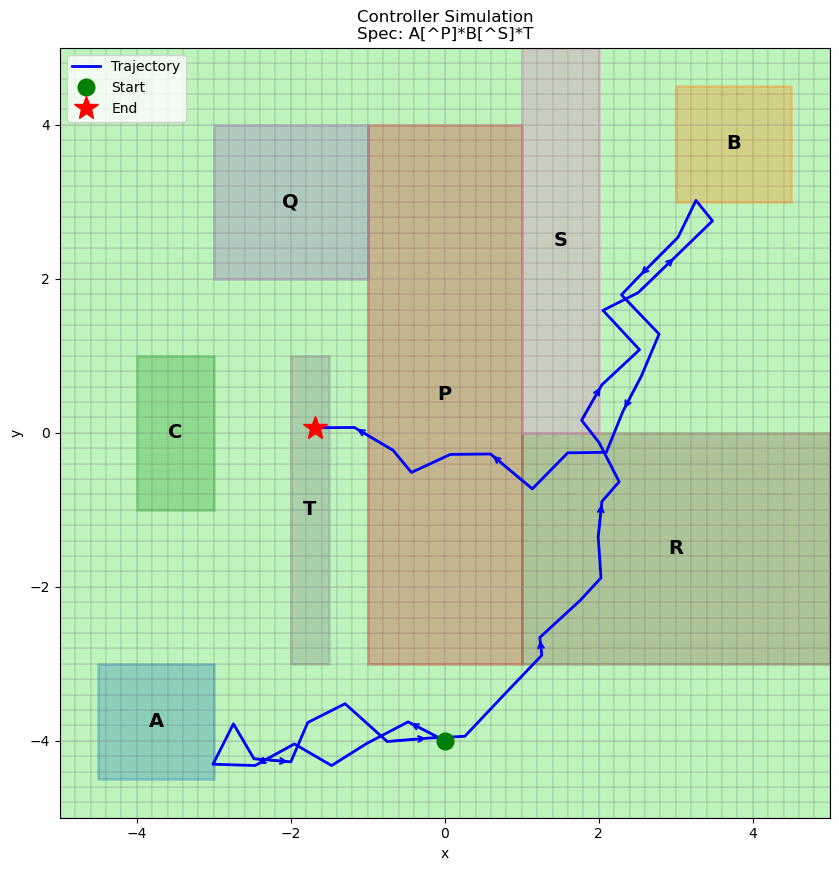

In [ ]:
# Run simulation
trajectory, nfa_trace = synth.simulate(start_position, max_steps=100, verbose=True)
print(f"\nTrajectory length: {len(trajectory)} steps")
print(f"Final NFA states: {nfa_trace[-1] if nfa_trace else 'N/A'}")
print(f"Reached accepting: {synth.is_accepting(nfa_trace[-1]) if nfa_trace else False}")

# Visualize trajectory
fig, ax = plt.subplots(figsize=(10, 10))
visualize_synthesis(synth, ax=ax, title="Controller Simulation")

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory', zorder=10)
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, label='Start', zorder=11)
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=18, label='End', zorder=11)

# Add arrows to show direction
n_arrows = min(10, len(trajectory) - 1)
step = max(1, len(trajectory) // n_arrows)
for i in range(0, len(trajectory) - 1, step):
    ax.annotate('', xy=(trajectory[i+1, 0], trajectory[i+1, 1]),
                xytext=(trajectory[i, 0], trajectory[i, 1]),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
                zorder=10)

ax.legend(loc='upper left')
plt.show()

## Summary Statistics

In [ ]:
nx, ny = abstraction.grid_shape
winning_cells = synth.get_winning_cells()

print("=" * 50)
print("PRODUCT SYNTHESIS SUMMARY")
print("=" * 50)
print(f"Specification: {spec}")
print(f"Grid: {nx} x {ny} = {abstraction.num_cells} cells")
print(f"Cell size (eta): {eta}")
print(f"")
print(f"NFA states: {len(synth.nfa.states)}")
print(f"NFA alphabet: {synth.nfa.alphabet}")
print(f"")
print(f"Product states: {len(synth.product.states)}")
print(f"Product accepting: {len(synth.product.accepting_states)}")
print(f"")
print(f"Safe cells: {len(synth.safe_automaton.safe_states)} ({100*len(synth.safe_automaton.safe_states)/abstraction.num_cells:.1f}%)")
print(f"Winning product states: {len(synth.winning_set)}")
print(f"Winning cells: {len(winning_cells)} ({100*len(winning_cells)/abstraction.num_cells:.1f}%)")
print(f"Reachability iterations: {len(synth.reach_sets) - 1}")

PRODUCT SYNTHESIS SUMMARY
Specification: A[^P]*B[^S]*T
Grid: 50 x 50 = 2500 cells
Cell size (eta): 0.2

NFA states: 14
NFA alphabet: {'T', [^S], [^P], 'A', 'B'}

Product states: 13964
Product accepting: 2184

Safe cells: 2500 (100.0%)
Winning product states: 11154
Winning cells: 2500 (100.0%)
Reachability iterations: 73
